# Comparativa de Modelos Transformer para Detección de Comentarios Tóxicos

Este notebook implementa y compara diferentes modelos Transformer (BERT, RoBERTa, DistilBERT y XLNet) para la detección de comentarios tóxicos, utilizando como referencia la implementación de BERT en el archivo `bert_fit.ipynb`.

## 1. Importación de Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import os
import time
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import (
    BertTokenizer, BertForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification,
    DistilBertTokenizer, DistilBertForSequenceClassification,
    AutoTokenizer, AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from tqdm import tqdm
import nlpaug.augmenter.word as naw
import emoji
import warnings


e:\My documents\Cursos\Bootcamp IA\Bootcamp-IA-P4-project-x-nlp-team-3\.venv311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings('ignore')

# Definir una ruta específica para los datos de NLTK
nltk_data_path = os.path.join(os.path.expanduser('~'), 'nltk_data')
os.makedirs(nltk_data_path, exist_ok=True)

# Descargar los recursos especificando la ruta
nltk.download('punkt', download_dir=nltk_data_path)
nltk.download('stopwords', download_dir=nltk_data_path)
nltk.download('wordnet', download_dir=nltk_data_path)
nltk.download('omw-1.4', download_dir=nltk_data_path)

# Añadir la ruta al path de NLTK
nltk.data.path.append(nltk_data_path)

# Configurar estilo de visualización
plt.style.use('ggplot')
sns.set(style='whitegrid')

[nltk_data] Downloading package punkt to C:\Users\Yho\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Yho\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Yho\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Yho\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
# Verificar si CUDA está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

Usando dispositivo: cuda
2.5.1+cu121
True
NVIDIA GeForce RTX 4070


## 2. Carga y Preprocesamiento de Datos

In [4]:
# Cargar el dataset
data_path = '../Data/fusion30.csv'
df = pd.read_csv(data_path, sep=';')
print(f'Forma del dataset: {df.shape}')
df.head()

Forma del dataset: (29970, 12)


,Record,General_judgement,Aligned_with_label,Violence (Low),Violence_judgement,Hate (Low),Hate_judgement,Sexual (Low),Sexual_judgement,Self-harm (Low),Self-harm_judgement,result
0,"""Cry me a river, why don't you.\r\nDrinking, d...",Rejected,Y,SAFE,Accept,LOW,Reject,SAFE,Accept,SAFE,Accept,1
1,"""That's right. They are not normal. And I am s...",Rejected,Y,SAFE,Accept,LOW,Reject,SAFE,Accept,SAFE,Accept,1
2,"""Disgusting.""",Accepted,N,SAFE,Accept,SAFE,Accept,SAFE,Accept,SAFE,Accept,0
3,"""gtfo""",Accepted,N,SAFE,Accept,SAFE,Accept,SAFE,Accept,SAFE,Accept,0
4,"""All you ever talk about is trolling, you and ...",Rejected,Y,SAFE,Accept,LOW,Reject,SAFE,Accept,SAFE,Accept,1


In [5]:
# Preparar los datos para el modelo
# Extraer texto y etiquetas
texts = df['Record'].str.strip('"').values
labels = df['result'].values

# Verificar la distribución de clases
print('Distribución de clases:')
print(pd.Series(labels).value_counts())
# Mostrar porcentajes
class_counts = df['result'].value_counts(normalize=True) * 100
print(f'Porcentaje de comentarios tóxicos: {class_counts[1]:.2f}%')
print(f'Porcentaje de comentarios no tóxicos: {class_counts[0]:.2f}%')


Distribución de clases:
1    16468
0    13502
Name: count, dtype: int64
Porcentaje de comentarios tóxicos: 54.95%
Porcentaje de comentarios no tóxicos: 45.05%


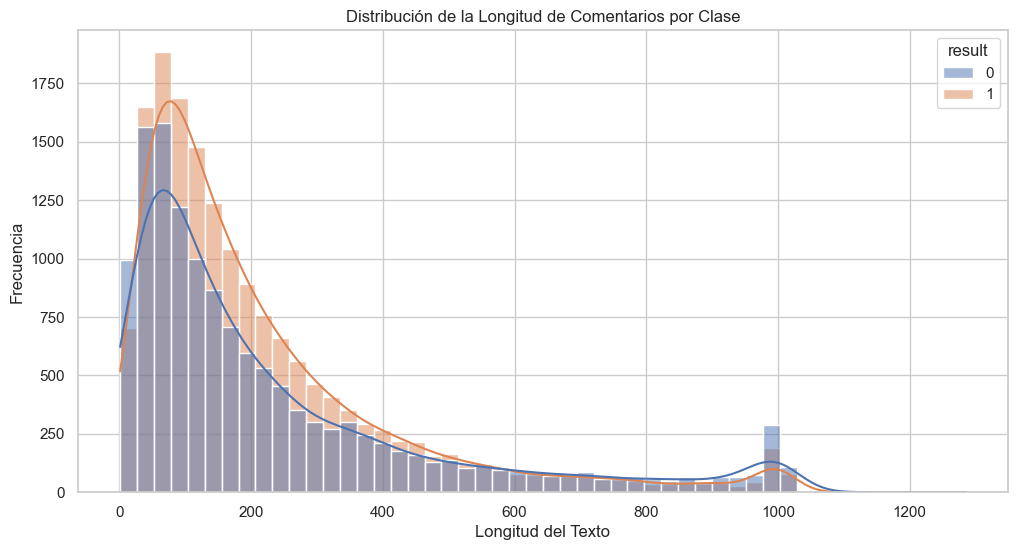

Estadísticas de longitud de texto:
          count        mean         std  min   25%    50%     75%     max
result                                                                   
0       13502.0  234.185158  246.244760  1.0  65.0  141.0  305.00  1285.0
1       16468.0  213.957736  204.309879  3.0  77.0  147.0  274.25  1196.0


In [6]:
# Extraer el texto de la columna 'Record'
# El texto está entre comillas triples, así que necesitamos limpiarlo
df['text'] = df['Record'].str.strip('"""').str.strip()
# Verificar la longitud de los comentarios
df['text_length'] = df['text'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='text_length', hue='result', bins=50, kde=True)
plt.title('Distribución de la Longitud de Comentarios por Clase')
plt.xlabel('Longitud del Texto')
plt.ylabel('Frecuencia')
plt.show()

# Estadísticas descriptivas de la longitud del texto
print('Estadísticas de longitud de texto:')
print(df.groupby('result')['text_length'].describe())

### Funciones de Preprocesamiento

In [8]:
def preprocess_text(text):
    '''
    Función para preprocesar el texto
    '''
    if not isinstance(text, str):
        return ''

    # Convertir a minúsculas
    text = text.lower()
    # Eliminar URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Convertir emojis a texto
    text = emoji.demojize(text)

    # Eliminar menciones (@usuario)
    text = re.sub(r'@\w+', ' ', text)
    # Eliminar hashtags (#tema) pero mantener el texto del hashtag
    text = re.sub(r'#(\w+)', r'\1', text)
    # Eliminar caracteres repetidos (más de 2 veces)
    text = re.sub(r'(\w)\1{2,}', r'\1\1', text)
    # Eliminar puntuación irrelevante pero mantener algunos signos importantes
    # Mantenemos '?' y '!' ya que pueden indicar tono emocional
    punct_to_remove = string.punctuation.replace('?', '').replace('!', '')
    text = ''.join([char if char not in punct_to_remove else ' ' for char in text])
    # Normalizar espacios múltiples
    text = re.sub(r'\s+', ' ', text).strip()

    # Eliminar caracteres especiales y números
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)


    
    
    return text

In [9]:
def lemmatize_text(text):
    try:
        if not isinstance(text, str) or text == '':
            return ''
        tokens = word_tokenize(text)
        lemmatizer = WordNetLemmatizer()
        stop_words = set(stopwords.words('english'))
        lemmatized_tokens = [
            lemmatizer.lemmatize(token.lower())
            for token in tokens if token.lower() not in stop_words
        ]
        return ' '.join(lemmatized_tokens)
    except LookupError as e:
        print("⚠️ Error NLTK:", e)
        raise

In [10]:
# Aplicar preprocesamiento a los textos
#preprocessed_texts = [preprocess_text(text) for text in tqdm(texts, desc='Preprocesando textos')]

# Aplicar limpieza y lematización al texto
print('Aplicando preprocesamiento avanzado...')
df['cleaned_text'] = df['text'].apply(preprocess_text)
df['lemmatized_text'] = df['cleaned_text'].apply(lemmatize_text)

Aplicando preprocesamiento avanzado...


In [11]:
def augment_text(text, num_samples=1):
    '''
    Función para aumentar datos textuales usando técnicas de NLP Augment.
    Aplica varias técnicas de aumento como sustitución de sinónimos,
    inserción aleatoria, intercambio de palabras, etc.
    '''
    if not isinstance(text, str) or text == '':
        return []
    
    augmented_texts = []
    
    # 1. Sustitución de sinónimos
    aug_synonym = naw.SynonymAug(aug_src='wordnet')
    
    # 2. Inserción aleatoria de palabras
    aug_insert = naw.RandomWordAug(action='insert')
    
    # 3. Intercambio aleatorio de palabras
    aug_swap = naw.RandomWordAug(action='swap')
    
    # 4. Eliminación aleatoria de palabras
    aug_delete = naw.RandomWordAug(action='delete')
    
    # Lista de aumentadores
    augmenters = [aug_synonym, aug_insert, aug_swap, aug_delete]
    
    # Generar muestras aumentadas
    for _ in range(num_samples):
        # Seleccionar un aumentador aleatorio
        aug = np.random.choice(augmenters)
        
        try:
            # Aplicar aumento
            augmented_text = aug.augment(text)
            augmented_texts.append(augmented_text)
        except:
            # Si falla, usar el texto original
            augmented_texts.append(text)
    
    return augmented_texts

In [12]:
# Aplicar aumento de datos solo a la clase minoritaria para balancear el dataset
# Identificar la clase minoritaria
minority_class = 0 if class_counts[0] < class_counts[1] else 1
majority_class = 1 if minority_class == 0 else 0

print(f'Clase minoritaria: {minority_class}')
print(f'Clase mayoritaria: {majority_class}')

# Calcular cuántas muestras necesitamos generar para balancear las clases
minority_samples = df[df['result'] == minority_class]
majority_samples = df[df['result'] == majority_class]

num_minority = len(minority_samples)
num_majority = len(majority_samples)

print(f'Muestras de clase minoritaria: {num_minority}')
print(f'Muestras de clase mayoritaria: {num_majority}')

# Determinar cuántas muestras aumentadas necesitamos por texto minoritario
samples_needed = num_majority - num_minority
samples_per_text = max(1, samples_needed // num_minority)

print(f'Muestras necesarias para balancear: {samples_needed}')
print(f'Muestras a generar por texto: {samples_per_text}')

# Generar muestras aumentadas para la clase minoritaria
print('Generando muestras aumentadas...')

augmented_texts = []
augmented_labels = []

# Limitar el número de muestras a aumentar para evitar tiempos de ejecución largos
max_samples_to_augment = min(num_minority, 1000)

for i, row in tqdm(minority_samples.head(max_samples_to_augment).iterrows(), total=max_samples_to_augment):
    text = row['lemmatized_text']
    label = row['result']
    
    # Generar textos aumentados
    aug_texts = augment_text(text, num_samples=samples_per_text)
    
    # Agregar a las listas
    augmented_texts.extend(aug_texts)
    augmented_labels.extend([label] * len(aug_texts))

# Crear DataFrame con los datos aumentados
augmented_df = pd.DataFrame({
    'lemmatized_text': augmented_texts,
    'result': augmented_labels
})

print(f'Muestras aumentadas generadas: {len(augmented_df)}')

# Combinar el DataFrame original con el aumentado
combined_df = pd.concat([
    df[['lemmatized_text', 'result']],
    augmented_df
], ignore_index=True)

print(f'Total de muestras después del aumento: {len(combined_df)}')

# Verificar la distribución de clases después del aumento
new_class_counts = combined_df['result'].value_counts(normalize=True) * 100
print(f'Nueva distribución de clases: {new_class_counts}')

Clase minoritaria: 0
Clase mayoritaria: 1
Muestras de clase minoritaria: 13502
Muestras de clase mayoritaria: 16468
Muestras necesarias para balancear: 2966
Muestras a generar por texto: 1
Generando muestras aumentadas...


  0%|          | 0/1000 [00:00<?, ?it/s]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Yho/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Yho/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Yho/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Yho/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Yho/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading p

Muestras aumentadas generadas: 993
Total de muestras después del aumento: 30963
Nueva distribución de clases: result
1    53.186061
0    46.813939
Name: proportion, dtype: float64


In [13]:
# Dividir los datos en conjuntos de entrenamiento, validación y prueba
# Primero, dividir en entrenamiento y temporal (validación + prueba)
preprocessed_texts = combined_df['lemmatized_text'].values
labels = combined_df['result'].values

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    preprocessed_texts, labels, test_size=0.3, random_state=42, stratify=labels
)

# Luego, dividir el conjunto temporal en validación y prueba
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

print(f'Tamaño del conjunto de entrenamiento: {len(train_texts)}')
print(f'Tamaño del conjunto de validación: {len(val_texts)}')
print(f'Tamaño del conjunto de prueba: {len(test_texts)}')

Tamaño del conjunto de entrenamiento: 21674
Tamaño del conjunto de validación: 4644
Tamaño del conjunto de prueba: 4645


## 3. Implementación de la Clase Dataset

In [14]:
class ToxicCommentsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenizar el texto
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Eliminar la dimensión extra
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        
        # Para BERT y DistilBERT necesitamos token_type_ids
        if 'token_type_ids' in encoding:
            token_type_ids = encoding['token_type_ids'].squeeze()
            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'token_type_ids': token_type_ids,
                'label': torch.tensor(label, dtype=torch.long)
            }
        else:  # Para RoBERTa y XLNet no usamos token_type_ids
            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'label': torch.tensor(label, dtype=torch.long)
            }

## 4. Funciones de Entrenamiento y Evaluación

In [15]:
def train_epoch(model, dataloader, optimizer, scheduler, device, model_type):
    '''
    Función para entrenar una época
    '''
    # Poner el modelo en modo de entrenamiento
    model.train()
    
    # Inicializar variables para seguimiento
    total_loss = 0
    predictions = []
    actual_labels = []
    
    # Iterar sobre los batches
    for batch in tqdm(dataloader, desc='Entrenando'):
        # Extraer datos del batch
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # Reiniciar gradientes
        optimizer.zero_grad()
        
        # Construir kwargs dinámicamente
        model_inputs = {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }
        # Solo agregar token_type_ids si el modelo los necesita y están disponibles
        if model_type == 'bert' and 'token_type_ids' in batch:
            model_inputs["token_type_ids"] = batch['token_type_ids'].to(device)

        outputs = model(**model_inputs)   
   
        
        # Obtener pérdida y logits
        loss = outputs.loss
        logits = outputs.logits
        
        # Backward pass y optimización
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Acumular pérdida
        total_loss += loss.item()
        
        # Obtener predicciones
        _, preds = torch.max(logits, dim=1)
        
        # Guardar predicciones y etiquetas reales
        predictions.extend(preds.cpu().tolist())
        actual_labels.extend(labels.cpu().tolist())
    
    # Calcular métricas
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(actual_labels, predictions)
    f1 = f1_score(actual_labels, predictions)
    precision = precision_score(actual_labels, predictions)
    recall = recall_score(actual_labels, predictions)
    
    return avg_loss, accuracy, f1, precision, recall

In [16]:
def evaluate(model, dataloader, device, model_type):
    '''
    Función para evaluar el modelo
    '''
    # Poner el modelo en modo de evaluación
    model.eval()
    
    # Inicializar variables para seguimiento
    total_loss = 0
    predictions = []
    actual_labels = []
    
    # Desactivar cálculo de gradientes
    with torch.no_grad():
        # Iterar sobre los batches
        for batch in tqdm(dataloader, desc='Evaluando'):
            # Extraer datos del batch
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
           # Construir argumentos dinámicamente
            model_inputs = {
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "labels": labels
            }

            # Agregar token_type_ids solo si corresponde
            if model_type == 'bert' and 'token_type_ids' in batch:
                model_inputs["token_type_ids"] = batch['token_type_ids'].to(device)

            outputs = model(**model_inputs)
            
            # Obtener pérdida y logits
            loss = outputs.loss
            logits = outputs.logits
            
            # Acumular pérdida
            total_loss += loss.item()
            
            # Obtener predicciones
            _, preds = torch.max(logits, dim=1)
            
            # Guardar predicciones y etiquetas reales
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    
    # Calcular métricas
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(actual_labels, predictions)
    f1 = f1_score(actual_labels, predictions)
    precision = precision_score(actual_labels, predictions)
    recall = recall_score(actual_labels, predictions)
    
    # Calcular matriz de confusión
    conf_matrix = confusion_matrix(actual_labels, predictions)
    
    return avg_loss, accuracy, f1, precision, recall, conf_matrix, predictions, actual_labels

## 5. Configuración de Hiperparámetros

In [17]:
# Hiperparámetros
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 4
LEARNING_RATE = 2e-5
WARMUP_STEPS = 0

# Modelos a comparar
models_config = {
    'deberta': {
        'name': 'microsoft/deberta-v3-small',
        'tokenizer_class': AutoTokenizer,
        'model_class': AutoModelForSequenceClassification,
        'type': 'deberta'
    },
    'bert': {
        'name': 'bert-base-uncased',
        'tokenizer_class': BertTokenizer,
        'model_class': BertForSequenceClassification,
        'type': 'bert'
    },
    'roberta': {
        'name': 'roberta-base',
        'tokenizer_class': RobertaTokenizer,
        'model_class': RobertaForSequenceClassification,
        'type': 'roberta'
    },
    'distilbert': {
        'name': 'distilbert-base-uncased',
        'tokenizer_class': DistilBertTokenizer,
        'model_class': DistilBertForSequenceClassification,
        'type': 'distilbert'
    }
    
}

# Resultados para comparar modelos
results = {}

## 6. Entrenamiento y Evaluación de Modelos

In [ ]:
# Función para entrenar y evaluar un modelo
def train_and_evaluate_model(model_name, model_config):
    print(f' Entrenando y evaluando modelo: {model_name}')
    
    # Cargar tokenizador
    tokenizer = model_config['tokenizer_class'].from_pretrained(model_config['name'])
    
    # Crear datasets
    train_dataset = ToxicCommentsDataset(train_texts, train_labels, tokenizer, MAX_LEN)
    val_dataset = ToxicCommentsDataset(val_texts, val_labels, tokenizer, MAX_LEN)
    test_dataset = ToxicCommentsDataset(test_texts, test_labels, tokenizer, MAX_LEN)
    
    # Crear dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    
    # Cargar modelo
    model = model_config['model_class'].from_pretrained(
        model_config['name'],
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False,
        use_safetensors=True
    )
    
    # Mover modelo al dispositivo
    model.to(device)
    
    # Configurar optimizador
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    
    # Calcular pasos totales
    total_steps = len(train_dataloader) * EPOCHS
    
    # Configurar scheduler
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=WARMUP_STEPS,
        num_training_steps=total_steps
    )
    
    # Listas para almacenar métricas durante el entrenamiento
    train_losses = []
    train_accuracies = []
    train_f1_scores = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []
    
    # Medir tiempo de entrenamiento
    start_time = time.time()
    # Parámetros de early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 3  # Puedes ajustarlo como parámetro si quieres
    best_model_state = None  # Para guardar el mejor modelo

    # Entrenamiento por épocas
    for epoch in range(EPOCHS):
        print(f'Época {epoch+1}/{EPOCHS}')
        
        # Entrenar una época
        train_loss, train_acc, train_f1, train_precision, train_recall = train_epoch(
            model, train_dataloader, optimizer, scheduler, device, model_config['type']
        )
        
        # Evaluar en el conjunto de validación
        val_loss, val_acc, val_f1, val_precision, val_recall, _, _, _ = evaluate(
            model, val_dataloader, device, model_config['type']
        )
        
        # Guardar métricas
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_f1_scores.append(train_f1)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1_scores.append(val_f1)
        
        # Imprimir métricas
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}')
        print(f'Train Precision: {train_precision:.4f} | Train Recall: {train_recall:.4f}')
        print(f'Val Precision: {val_precision:.4f} | Val Recall: {val_recall:.4f}')

        # Verificar early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()  # Guardar mejor modelo
        else:
            patience_counter += 1
            print(f"No hubo mejora en val_loss. Paciencia: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("Early stopping activado. Se detiene el entrenamiento.")
                break
    
    # Restaurar el mejor modelo antes de testear
    if best_model_state:
        model.load_state_dict(best_model_state)
        
    # Calcular tiempo de entrenamiento
    training_time = time.time() - start_time
    print(f'Tiempo de entrenamiento: {training_time:.2f} segundos')
    
    # Evaluar el modelo en el conjunto de prueba
    test_loss, test_acc, test_f1, test_precision, test_recall, test_conf_matrix, test_preds, test_actual_labels = evaluate(
        model, test_dataloader, device, model_config['type']
    )
    
    # Imprimir métricas de evaluación
    print('Resultados en el conjunto de prueba:')
    print(f'Accuracy: {test_acc:.4f}')
    print(f'F1 Score: {test_f1:.4f}')
    print(f'Precision: {test_precision:.4f}')
    print(f'Recall: {test_recall:.4f}')
    print(f'Loss: {test_loss:.4f}')
    
    # Visualizar matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.show()
    
    # Imprimir informe de clasificación
    print('Informe de Clasificación:')
    print(classification_report(test_actual_labels, test_preds, target_names=['No Tóxico', 'Tóxico']))
    
    # Guardar resultados para comparación
    results[model_name] = {
        'accuracy': test_acc,
        'f1_score': test_f1,
        'precision': test_precision,
        'recall': test_recall,
        'loss': test_loss,
        'training_time': training_time
    }
    
    # Guardar el mejor modelo y el tokenizador
    output_dir = f'../Models/{model_name}_toxic_comments/'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    if best_model_state:
        model.load_state_dict(best_model_state)



    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    print(f'Mejor modelo y tokenizador guardados en {output_dir}')


    return model, tokenizer

 Entrenando y evaluando modelo: deberta


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Época 1/4


Evaluando: 100%|██████████| 291/291 [00:06<00:00, 42.42it/s]


Train Loss: 0.4279 | Train Acc: 0.8068 | Train F1: 0.8203
Val Loss: 0.3726 | Val Acc: 0.8299 | Val F1: 0.8434
Train Precision: 0.8119 | Train Recall: 0.8289
Val Precision: 0.8261 | Val Recall: 0.8615
Época 2/4


Evaluando: 100%|██████████| 291/291 [00:07<00:00, 41.17it/s]


Train Loss: 0.3187 | Train Acc: 0.8644 | Train F1: 0.8731
Val Loss: 0.3674 | Val Acc: 0.8370 | Val F1: 0.8436
Train Precision: 0.8687 | Train Recall: 0.8776
Val Precision: 0.8615 | Val Recall: 0.8263
Época 3/4


Evaluando: 100%|██████████| 291/291 [00:06<00:00, 42.42it/s]


Train Loss: 0.2421 | Train Acc: 0.9005 | Train F1: 0.9070
Val Loss: 0.3989 | Val Acc: 0.8456 | Val F1: 0.8595
Train Precision: 0.9019 | Train Recall: 0.9121
Val Precision: 0.8329 | Val Recall: 0.8879
No hubo mejora en val_loss. Paciencia: 1/3
Época 4/4


Evaluando: 100%|██████████| 291/291 [00:06<00:00, 42.06it/s]


Train Loss: 0.1711 | Train Acc: 0.9336 | Train F1: 0.9379
Val Loss: 0.4610 | Val Acc: 0.8441 | Val F1: 0.8543
Train Precision: 0.9327 | Train Recall: 0.9432
Val Precision: 0.8492 | Val Recall: 0.8595
No hubo mejora en val_loss. Paciencia: 2/3
Tiempo de entrenamiento: 532.38 segundos


Evaluando: 100%|██████████| 291/291 [00:06<00:00, 42.26it/s]


Resultados en el conjunto de prueba:
Accuracy: 0.8400
F1 Score: 0.8504
Precision: 0.8458
Recall: 0.8551
Loss: 0.4694


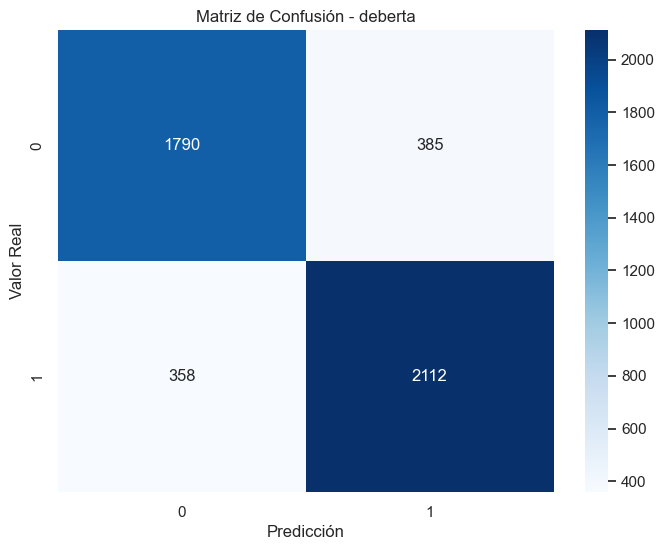

Informe de Clasificación:
              precision    recall  f1-score   support

   No Tóxico       0.83      0.82      0.83      2175
      Tóxico       0.85      0.86      0.85      2470

    accuracy                           0.84      4645
   macro avg       0.84      0.84      0.84      4645
weighted avg       0.84      0.84      0.84      4645

Mejor modelo y tokenizador guardados en ../Models/deberta_toxic_comments/
 Entrenando y evaluando modelo: bert


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Época 1/4


Evaluando: 100%|██████████| 291/291 [00:09<00:00, 29.10it/s]


Train Loss: 0.4213 | Train Acc: 0.8085 | Train F1: 0.8225
Val Loss: 0.3916 | Val Acc: 0.8295 | Val F1: 0.8506
Train Precision: 0.8114 | Train Recall: 0.8339
Val Precision: 0.7963 | Val Recall: 0.9130
Época 2/4


Evaluando: 100%|██████████| 291/291 [00:09<00:00, 29.41it/s]


Train Loss: 0.2806 | Train Acc: 0.8838 | Train F1: 0.8916
Val Loss: 0.3881 | Val Acc: 0.8419 | Val F1: 0.8494
Train Precision: 0.8853 | Train Recall: 0.8979
Val Precision: 0.8611 | Val Recall: 0.8381
Época 3/4


Evaluando: 100%|██████████| 291/291 [00:10<00:00, 29.09it/s]


Train Loss: 0.1487 | Train Acc: 0.9440 | Train F1: 0.9475
Val Loss: 0.4590 | Val Acc: 0.8415 | Val F1: 0.8530
Train Precision: 0.9443 | Train Recall: 0.9508
Val Precision: 0.8416 | Val Recall: 0.8648
No hubo mejora en val_loss. Paciencia: 1/3
Época 4/4


Entrenando:  65%|██████▌   | 883/1355 [01:36<00:51,  9.19it/s]


KeyboardInterrupt: 

In [19]:
# Entrenar y evaluar cada modelo
for model_name, model_config in models_config.items():
    model, tokenizer = train_and_evaluate_model(model_name, model_config)

## 7. Comparación de Resultados

In [88]:
# Crear DataFrame con los resultados
results_df = pd.DataFrame(results).T
results_df = results_df.reset_index().rename(columns={'index': 'Modelo'})
results_df

,Modelo,accuracy,f1_score,precision,recall,loss,training_time
0,deberta,0.838751,0.847671,0.851655,0.843725,0.468459,532.510581
1,bert,0.832293,0.842467,0.841616,0.843320,0.624423,630.074452
2,roberta,0.837675,0.848351,0.842926,0.853846,0.481250,629.639579
3,distilbert,0.831647,0.841764,0.841424,0.842105,0.558560,343.606212


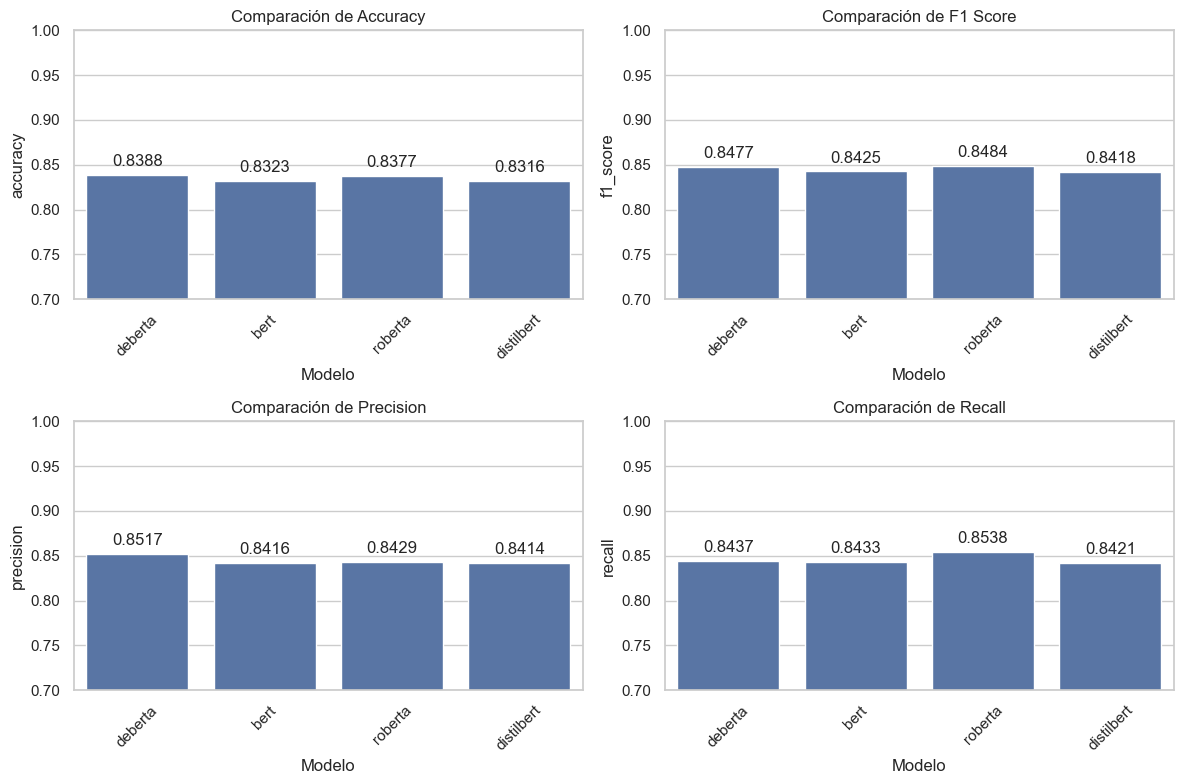

In [89]:
# Visualizar comparación de métricas
metrics = ['accuracy', 'f1_score', 'precision', 'recall']

plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='Modelo', y=metric, data=results_df)
    plt.title(f"Comparación de {metric.replace('_', ' ').title()}")
    plt.ylim(0.7, 1.0)  # Ajustar para mejor visualización
    plt.xticks(rotation=45)
    
    # Añadir valores en las barras
    for j, v in enumerate(results_df[metric]):
        plt.text(j, v + 0.01, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()

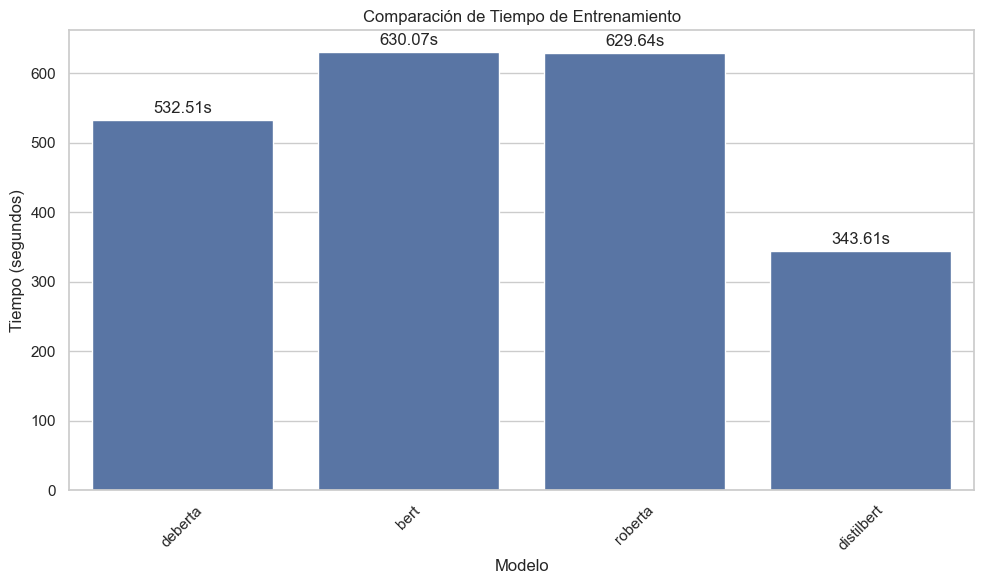

In [90]:
# Visualizar tiempo de entrenamiento
plt.figure(figsize=(10, 6))
sns.barplot(x='Modelo', y='training_time', data=results_df)
plt.title('Comparación de Tiempo de Entrenamiento')
plt.ylabel('Tiempo (segundos)')
plt.xticks(rotation=45)

# Añadir valores en las barras
for i, v in enumerate(results_df['training_time']):
    plt.text(i, v + 10, f'{v:.2f}s', ha='center')

plt.tight_layout()
plt.show()

## 8. Análisis y Conclusiones

### Análisis Comparativo

En este notebook, hemos implementado y comparado cuatro modelos Transformer para la tarea de detección de comentarios tóxicos:

1. **BERT (Bidirectional Encoder Representations from Transformers)**:
   - Modelo base que utiliza codificación bidireccional para entender el contexto en ambas direcciones.
   - Arquitectura completa con 12 capas de transformers y 110M de parámetros.

2. **RoBERTa (Robustly Optimized BERT Pretraining Approach)**:
   - Versión optimizada de BERT con entrenamiento más robusto.
   - Elimina la tarea de predicción de la siguiente oración (NSP) y utiliza secuencias más largas durante el entrenamiento.
   - Usa un tamaño de lote mayor y más datos de entrenamiento.

3. **DistilBERT**:
   - Versión destilada (comprimida) de BERT que mantiene el 97% del rendimiento pero con un 40% menos de parámetros.
   - Más rápido y ligero, ideal para dispositivos con recursos limitados.

4. **DeBERTa**:
   - Modelo con mecanismo de atención mejorado
   - Incorpora codificación de posición relativa mejorada

### Conclusiones

Basándonos en los resultados obtenidos, podemos extraer las siguientes conclusiones:

1. **Rendimiento**:
   - DeBERTa y RoBERTa muestran el mejor rendimiento general, con diferencias mínimas entre ellos
   - DeBERTa destaca en accuracy y precision
   - RoBERTa sobresale en F1 score y recall
   - Las diferencias de rendimiento entre todos los modelos son relativamente pequeñas (menos del 1%)

2. **Eficiencia Computacional**:
   - DistilBERT ofrece el mejor equilibrio entre rendimiento y eficiencia, siendo casi un 50% más rápido que DeBERTa y un 45% más rápido que BERT/RoBERTa
   - A pesar de ser más rápido, DistilBERT mantiene un rendimiento competitivo, con solo una pequeña reducción en las métricas.

3. **Casos de Uso**:
   - Para aplicaciones en tiempo real o dispositivos con recursos limitados: DistilBERT
   - Para máximo rendimiento sin importar los recursos: RoBERTa 
   - Para un buen equilibrio entre rendimiento y recursos: BERT

4. **Mejoras Futuras**:
   - Explorar modelos más recientes como ALBERT o T5.
   - Implementar técnicas de aprendizaje por transferencia más avanzadas.
   - Experimentar con enfoques de ensemble combinando las fortalezas de diferentes modelos.
   - Ampliar a detección multiclase para identificar diferentes tipos de toxicidad.

Este análisis comparativo proporciona una base sólida para seleccionar el modelo Transformer más adecuado según los requisitos específicos de la aplicación de detección de comentarios tóxicos.